In [1]:
import torch
import torch.nn as nn
import os
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
import random
from torch.utils.data import DataLoader
from collections import Counter
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns

#Architecture

In [ ]:
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [ ]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * 7 * 7, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

#Intersection over Union

In [ ]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    # print("IOU:",intersection / (box1_area + box2_area - intersection + 1e-6))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

#NMS Function

In [ ]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

#LOSS Function

In [ ]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper and VOC dataset is 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

#DataSet

In [ ]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(
        self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(float(x))
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transform:
            # image = self.transform(image)
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i,j represents the cell row and cell column
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:
            
            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)
            
            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object already found for specific cell i,j
            # Note: This means we restrict to ONE object
            # per cell!
            if label_matrix[i, j, 20] == 0:
                # Set that there exists an object
                label_matrix[i, j, 20] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 21:25] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

#MAP

In [ ]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        
        fr = open("recalls.txt","w")
        for i in list(recalls):
          fr.write(str(float(i))+"\n")
        
        fp = open("precisions.txt","w")
        for i in list(precisions):
          fp.write(str(float(i))+"\n")

        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / (len(average_precisions))

#Cell_to_Boxes


In [ ]:
def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

#Bounding Boxes

In [ ]:
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    # model.train()
    return all_pred_boxes, all_true_boxes

#Training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
data_name = "data_500"
data_name_zip = data_name+".zip"
drive_path = "/content/drive/MyDrive/"
path = os.path.join(drive_path,data_name)

In [ ]:
if not os.path.exists(path):
  !zip -F "data_500.zip" --out "fixed.zip"
  !unzip "fixed.zip" -d "/content"
else:
  print("Alert :: DATA ALREADY EXIST !!!!!")

Fix archive (-F) - assume mostly intact archive
Zip entry offsets do not need adjusting
 copying: data_500/images/
 copying: data_500/images/0001.jpg
 copying: data_500/images/0002.jpg
 copying: data_500/images/0003.jpg
 copying: data_500/images/0004.jpg
 copying: data_500/images/0005.jpg
 copying: data_500/images/0006.jpg
 copying: data_500/images/0007.jpg
 copying: data_500/images/0008.jpg
 copying: data_500/images/0009.jpg
 copying: data_500/images/0010.jpg
 copying: data_500/images/0011.jpg
 copying: data_500/images/0012.jpg
 copying: data_500/images/0013.jpg
 copying: data_500/images/0014.jpg
 copying: data_500/images/0015.jpg
 copying: data_500/images/0016.jpg
 copying: data_500/images/0017.jpg
 copying: data_500/images/0018.jpg
 copying: data_500/images/0019.jpg
 copying: data_500/images/0020.jpg
 copying: data_500/images/0021.jpg
 copying: data_500/images/0022.jpg
 copying: data_500/images/0023.jpg
 copying: data_500/images/0024.jpg
 copying: data_500/images/0025.jpg
 copying: 

In [ ]:
import cv2
base_path = data_name+"/images/"
for img in os.listdir(base_path):
  read = cv2.imread(base_path + img)
  outfile = img.split('.')[0] + '.jpg'
  cv2.imwrite(base_path+outfile,read,[int(cv2.IMWRITE_JPEG_QUALITY), 200])

In [ ]:
def clean_data(data_name):
  base_path = data_name+"/images/"
  for img in os.listdir(base_path):
    read = cv2.imread(base_path + img)
    outfile = img.split('.')[0] + '.jpg'
    cv2.imwrite(base_path+outfile,read,[int(cv2.IMWRITE_JPEG_QUALITY), 200])
  df_train = pd.read_csv(data_name+"/train_csv.csv", names = ["image", "label"])
  df_train.head()
  df_train["image"] = df_train["image"].apply(lambda x: x.split('.')[0]+".jpg")
  df_train.head()
  df_train.to_csv("./"+data_name+"/train_csv.csv",header=False,index=False)
  df_test = pd.read_csv(data_name+"/test_csv.csv", names = ["image", "label"])
  df_test.head()
  df_test["image"] = df_test["image"].apply(lambda x: x.split('.')[0]+".jpg")
  df_test.head()
  df_test.to_csv("./"+data_name+"/test_csv.csv",header=False,index=False)

In [ ]:
clean_data(data_name)

In [ ]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [ ]:
LEARNING_RATE = 1e-5
BATCH_SIZE = 4 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0 #1e-4
EPOCHS = 200
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = os.path.join(data_name,"images")
LABEL_DIR = os.path.join(data_name,"labels")

In [ ]:
def model_evaluation(test_loader,model,loss_fn):
  model.eval()

  pred_boxes, target_boxes = get_bboxes(
            test_loader, model, iou_threshold=0.5, threshold=0.4,device = DEVICE
        )

  mean_avg_prec = mean_average_precision(
              pred_boxes,target_boxes, iou_threshold=0.5, box_format="midpoint"
          )

  mean_loss = []
  for batch_idx, (x, y) in enumerate(test_loader):
    x, y = x.to(DEVICE), y.to(DEVICE)
    out = model(x)
    loss = loss_fn(out, y)
    mean_loss.append(loss.item())
  
  model.train()
  return (sum(mean_loss)/(len(mean_loss)+1)),mean_avg_prec


In [ ]:
def train_fn(train_loader, model, optimizer, loss_fn):

    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())
    

    # print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

    return (sum(mean_loss)/(len(mean_loss)+1))

In [ ]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=20)
model = model.to(DEVICE)
optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
loss_fn = YoloLoss()

In [ ]:
transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

In [ ]:
train_dataset = VOCDataset(
        os.path.join("/content",data_name,"train_csv.csv"),
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

test_dataset = VOCDataset(
        os.path.join("/content",data_name,"test_csv.csv"), transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

In [ ]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

#SAVING AND LOADING

In [ ]:
def save_data(loss_data,accuracy_data,algo):
  name_loss = 'loss_data'+algo+'.pt'
  name_accuracy = 'accuracy_data'+algo+'.pt'
  path1 = "/content/drive/MyDrive/"+name_loss
  path2 = "/content/drive/MyDrive/"+name_accuracy 
  torch.save(loss_data, path1)
  torch.save(accuracy_data, path2)

In [ ]:
loss_arr = []
train_map = []
test_map = []

EPOCHS = 100
best_map = 0

for epoch in range(EPOCHS):
  
          model.eval()
          pred_boxes, target_boxes = get_bboxes(
              train_loader, model, iou_threshold=0.5, threshold=0.4,device = DEVICE
          )

          mean_avg_prec = mean_average_precision(
              pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
          )


          test_loss,test_mean_avg_prec = model_evaluation(test_loader,model,loss_fn)

          print(f"EPOCH :{epoch} Train mAP: {mean_avg_prec*100} Test mAP : {test_mean_avg_prec*100} ")

          model.train()


          if mean_avg_prec > best_map:
            check_point_name = data_name+'_'+str(EPOCHS)+'.pth'
            path = "/content/drive/MyDrive/"+check_point_name 
            torch.save(model.state_dict(), path)
            # download checkpoint file
            # files.download('checkpoint.pth')

            # model_save_name = 'best_map'+'.pt'
            # best_acc = mean_avg_prec
            # torch.save({
            #   'epoch': epoch,
            #   'model_state_dict': model.state_dict(),
            #   'optimizer_state_dict': optimizer.state_dict(),
            #   'loss': loss,
            #   }, path)
            print("Last Epoch saved :",epoch)


          loss = train_fn(train_loader, model, optimizer, loss_fn)

          print(f" \n Train LOSS: {loss} Test LOSS : {test_loss}")

          loss_arr.append(loss)
          train_map.append(mean_avg_prec*100)
          test_map.append(test_mean_avg_prec*100)


EPOCH :0 Train mAP: 0.0 Test mAP : 0.0 


100%|██████████| 99/99 [00:15<00:00,  6.53it/s, loss=23.4]

 
 Train LOSS: 34.20640413284302 Test LOSS : 88.87555572509766


EPOCH :1 Train mAP: 3.0841798782348633 Test mAP : 0.5397395491600037 
Last Epoch saved : 1


100%|██████████| 99/99 [00:15<00:00,  6.37it/s, loss=9.2]

 
 Train LOSS: 14.745710401535034 Test LOSS : 20.819646186828614


EPOCH :2 Train mAP: 19.370025634765625 Test mAP : 5.019244194030762 
Last Epoch saved : 2


100%|██████████| 99/99 [00:15<00:00,  6.29it/s, loss=7.22]

 
 Train LOSS: 10.08676736354828 Test LOSS : 16.646172409057616


EPOCH :3 Train mAP: 41.692787170410156 Test mAP : 4.6520609855651855 
Last Epoch saved : 3


100%|██████████| 99/99 [00:16<00:00,  6.18it/s, loss=13.5]

 
 Train LOSS: 7.784503669738769 Test LOSS : 14.626116333007813


EPOCH :4 Train mAP: 56.84514617919922 Test mAP : 8.357282638549805 
Last Epoch saved : 4


100%|██████████| 99/99 [00:16<00:00,  6.10it/s, loss=6.72]

 
 Train LOSS: 6.483884506225586 Test LOSS : 13.995029792785644


EPOCH :5 Train mAP: 76.24322509765625 Test mAP : 9.176865577697754 
Last Epoch saved : 5


100%|██████████| 99/99 [00:16<00:00,  6.08it/s, loss=5.08]

 
 Train LOSS: 5.610366070270539 Test LOSS : 13.036387062072754


EPOCH :6 Train mAP: 88.99046325683594 Test mAP : 6.109374046325684 
Last Epoch saved : 6


100%|██████████| 99/99 [00:16<00:00,  6.01it/s, loss=4.98]

 
 Train LOSS: 5.145805900096893 Test LOSS : 12.35631196975708


EPOCH :7 Train mAP: 91.95221710205078 Test mAP : 5.681399822235107 
Last Epoch saved : 7


100%|██████████| 99/99 [00:16<00:00,  5.97it/s, loss=5.09]

 
 Train LOSS: 4.692822191715241 Test LOSS : 11.441977043151855


EPOCH :8 Train mAP: 94.7679214477539 Test mAP : 9.799880981445312 
Last Epoch saved : 8


100%|██████████| 99/99 [00:16<00:00,  5.97it/s, loss=4.75]

 
 Train LOSS: 4.341215443611145 Test LOSS : 9.907535495758056


EPOCH :9 Train mAP: 97.41178131103516 Test mAP : 9.874103546142578 
Last Epoch saved : 9


100%|██████████| 99/99 [00:16<00:00,  6.06it/s, loss=3.72]

 
 Train LOSS: 4.2004202938079835 Test LOSS : 10.41826416015625


EPOCH :10 Train mAP: 97.46044921875 Test mAP : 13.810319900512695 
Last Epoch saved : 10


100%|██████████| 99/99 [00:16<00:00,  6.07it/s, loss=3.47]

 
 Train LOSS: 3.754939284324646 Test LOSS : 10.163128051757813


EPOCH :11 Train mAP: 96.50709533691406 Test mAP : 17.873931884765625 
Last Epoch saved : 11


100%|██████████| 99/99 [00:16<00:00,  5.97it/s, loss=3.62]

 
 Train LOSS: 3.488303642272949 Test LOSS : 9.969432106018067


EPOCH :12 Train mAP: 99.2464370727539 Test mAP : 15.225598335266113 
Last Epoch saved : 12


100%|██████████| 99/99 [00:16<00:00,  6.06it/s, loss=2.85]

 
 Train LOSS: 3.348328876495361 Test LOSS : 10.107373046875


EPOCH :13 Train mAP: 99.37714385986328 Test mAP : 17.624773025512695 
Last Epoch saved : 13


100%|██████████| 99/99 [00:16<00:00,  6.00it/s, loss=3.25]

 
 Train LOSS: 3.1433713173866273 Test LOSS : 9.64205961227417


EPOCH :14 Train mAP: 98.94281005859375 Test mAP : 12.774486541748047 
Last Epoch saved : 14


100%|██████████| 99/99 [00:16<00:00,  6.05it/s, loss=3.57]

 
 Train LOSS: 3.0067472767829897 Test LOSS : 9.800322799682617


EPOCH :15 Train mAP: 99.27808380126953 Test mAP : 17.852418899536133 
Last Epoch saved : 15


100%|██████████| 99/99 [00:16<00:00,  6.08it/s, loss=3.46]

 
 Train LOSS: 2.999418702125549 Test LOSS : 9.420007877349853


EPOCH :16 Train mAP: 100.00001525878906 Test mAP : 21.403629302978516 
Last Epoch saved : 16


100%|██████████| 99/99 [00:16<00:00,  6.06it/s, loss=2.37]

 
 Train LOSS: 2.761917073726654 Test LOSS : 9.096655406951903


EPOCH :17 Train mAP: 98.41999053955078 Test mAP : 16.288408279418945 
Last Epoch saved : 17


100%|██████████| 99/99 [00:16<00:00,  5.93it/s, loss=2.9]

 
 Train LOSS: 2.8646272826194763 Test LOSS : 8.933700819015503


EPOCH :18 Train mAP: 99.08565521240234 Test mAP : 20.396726608276367 
Last Epoch saved : 18


100%|██████████| 99/99 [00:16<00:00,  6.10it/s, loss=2.6]

 
 Train LOSS: 2.536998372077942 Test LOSS : 8.595156383514404


EPOCH :19 Train mAP: 98.80277252197266 Test mAP : 18.089914321899414 
Last Epoch saved : 19


100%|██████████| 99/99 [00:16<00:00,  6.05it/s, loss=1.75]

 
 Train LOSS: 2.528431069850922 Test LOSS : 8.584922761917115


EPOCH :20 Train mAP: 98.7484359741211 Test mAP : 24.312137603759766 
Last Epoch saved : 20


100%|██████████| 99/99 [00:16<00:00,  6.10it/s, loss=1.97]

 
 Train LOSS: 2.3979826092720034 Test LOSS : 8.529341316223144


EPOCH :21 Train mAP: 99.01701354980469 Test mAP : 19.160207748413086 
Last Epoch saved : 21


100%|██████████| 99/99 [00:16<00:00,  6.09it/s, loss=2.53]

 
 Train LOSS: 2.332945399284363 Test LOSS : 8.602291507720947


EPOCH :22 Train mAP: 99.63731384277344 Test mAP : 20.981704711914062 
Last Epoch saved : 22


100%|██████████| 99/99 [00:16<00:00,  6.12it/s, loss=2.96]

 
 Train LOSS: 2.2089111542701723 Test LOSS : 8.274750804901123


EPOCH :23 Train mAP: 100.00001525878906 Test mAP : 22.55145263671875 
Last Epoch saved : 23


100%|██████████| 99/99 [00:16<00:00,  6.00it/s, loss=2.72]

 
 Train LOSS: 2.1320544803142547 Test LOSS : 8.444795694351196


EPOCH :24 Train mAP: 98.54070281982422 Test mAP : 27.0609130859375 
Last Epoch saved : 24


100%|██████████| 99/99 [00:16<00:00,  6.06it/s, loss=1.69]

 
 Train LOSS: 2.0193878769874574 Test LOSS : 8.374584255218506


EPOCH :25 Train mAP: 99.70220184326172 Test mAP : 20.405139923095703 
Last Epoch saved : 25


100%|██████████| 99/99 [00:16<00:00,  6.06it/s, loss=1.68]

 
 Train LOSS: 1.8473565924167632 Test LOSS : 7.756837844848633


EPOCH :26 Train mAP: 100.00001525878906 Test mAP : 22.4634952545166 
Last Epoch saved : 26


100%|██████████| 99/99 [00:16<00:00,  6.05it/s, loss=1.41]

 
 Train LOSS: 1.9012571167945862 Test LOSS : 7.167454261779785


EPOCH :27 Train mAP: 99.31279754638672 Test mAP : 25.51473045349121 
Last Epoch saved : 27


100%|██████████| 99/99 [00:16<00:00,  6.05it/s, loss=3.09]

 
 Train LOSS: 1.8800999748706817 Test LOSS : 7.9100034713745115


EPOCH :28 Train mAP: 100.00001525878906 Test mAP : 23.46422004699707 
Last Epoch saved : 28


100%|██████████| 99/99 [00:16<00:00,  6.03it/s, loss=1.68]

 
 Train LOSS: 1.8385865700244903 Test LOSS : 7.612110004425049


EPOCH :29 Train mAP: 98.923583984375 Test mAP : 22.31413459777832 
Last Epoch saved : 29


100%|██████████| 99/99 [00:16<00:00,  6.01it/s, loss=1.94]

 
 Train LOSS: 1.8167543148994445 Test LOSS : 7.9243994140625


EPOCH :30 Train mAP: 99.69049072265625 Test mAP : 23.097917556762695 
Last Epoch saved : 30


100%|██████████| 99/99 [00:16<00:00,  6.10it/s, loss=1.29]

 
 Train LOSS: 1.8501149535179138 Test LOSS : 7.630829734802246


EPOCH :31 Train mAP: 98.19300079345703 Test mAP : 24.383445739746094 
Last Epoch saved : 31


100%|██████████| 99/99 [00:16<00:00,  6.07it/s, loss=2.01]

 
 Train LOSS: 1.8750380182266235 Test LOSS : 7.633361339569092


EPOCH :32 Train mAP: 99.0648193359375 Test mAP : 21.29145050048828 
Last Epoch saved : 32


100%|██████████| 99/99 [00:16<00:00,  6.09it/s, loss=1.38]

 
 Train LOSS: 1.7330927085876464 Test LOSS : 8.100164375305177


EPOCH :33 Train mAP: 99.74620056152344 Test mAP : 25.447973251342773 
Last Epoch saved : 33


100%|██████████| 99/99 [00:16<00:00,  6.06it/s, loss=1.33]

 
 Train LOSS: 1.6060654312372207 Test LOSS : 7.489002838134765


EPOCH :34 Train mAP: 99.7442626953125 Test mAP : 29.030353546142578 
Last Epoch saved : 34


100%|██████████| 99/99 [00:16<00:00,  6.12it/s, loss=1.49]

 
 Train LOSS: 1.6651423007249833 Test LOSS : 7.259648971557617


EPOCH :35 Train mAP: 99.74555969238281 Test mAP : 25.413820266723633 
Last Epoch saved : 35


100%|██████████| 99/99 [00:16<00:00,  5.98it/s, loss=1.01]

 
 Train LOSS: 1.9053286111354828 Test LOSS : 7.859287796020507


EPOCH :36 Train mAP: 99.7390365600586 Test mAP : 21.46976089477539 
Last Epoch saved : 36


100%|██████████| 99/99 [00:16<00:00,  6.06it/s, loss=1.81]

 
 Train LOSS: 1.8057435142993927 Test LOSS : 7.53873291015625


EPOCH :37 Train mAP: 98.93580627441406 Test mAP : 22.919517517089844 
Last Epoch saved : 37


100%|██████████| 99/99 [00:16<00:00,  6.04it/s, loss=1.21]

 
 Train LOSS: 1.9091184961795806 Test LOSS : 7.736375617980957


EPOCH :38 Train mAP: 99.4679946899414 Test mAP : 29.46866226196289 
Last Epoch saved : 38


100%|██████████| 99/99 [00:16<00:00,  6.12it/s, loss=1.53]

 
 Train LOSS: 1.8609909254312516 Test LOSS : 7.716630249023438


EPOCH :39 Train mAP: 97.61653900146484 Test mAP : 29.549169540405273 
Last Epoch saved : 39


100%|██████████| 99/99 [00:16<00:00,  6.12it/s, loss=1.61]

 
 Train LOSS: 1.6227164816856385 Test LOSS : 6.162276859283447


EPOCH :40 Train mAP: 99.71485137939453 Test mAP : 29.32621192932129 
Last Epoch saved : 40


100%|██████████| 99/99 [00:16<00:00,  6.10it/s, loss=1.56]

 
 Train LOSS: 1.5670087242126465 Test LOSS : 6.9059594631195065


EPOCH :41 Train mAP: 99.29964447021484 Test mAP : 38.687259674072266 
Last Epoch saved : 41


100%|██████████| 99/99 [00:16<00:00,  5.98it/s, loss=1.78]

 
 Train LOSS: 1.52537874519825 Test LOSS : 7.109990282058716


EPOCH :42 Train mAP: 100.00001525878906 Test mAP : 35.43228530883789 
Last Epoch saved : 42


100%|██████████| 99/99 [00:16<00:00,  5.93it/s, loss=1.4]

 
 Train LOSS: 1.4760913527011872 Test LOSS : 6.981978225708008


EPOCH :43 Train mAP: 100.00001525878906 Test mAP : 33.41987609863281 
Last Epoch saved : 43


100%|██████████| 99/99 [00:16<00:00,  6.00it/s, loss=1.59]

 
 Train LOSS: 1.3335620486736297 Test LOSS : 6.693172454833984


EPOCH :44 Train mAP: 100.00001525878906 Test mAP : 34.65611267089844 
Last Epoch saved : 44


100%|██████████| 99/99 [00:16<00:00,  6.02it/s, loss=1.82]

 
 Train LOSS: 1.3988783740997315 Test LOSS : 7.117513675689697


EPOCH :45 Train mAP: 99.35554504394531 Test mAP : 43.130615234375 
Last Epoch saved : 45


100%|██████████| 99/99 [00:16<00:00,  5.98it/s, loss=1.46]

 
 Train LOSS: 1.550745370388031 Test LOSS : 6.858841905593872


EPOCH :46 Train mAP: 96.7821044921875 Test mAP : 36.85014343261719 
Last Epoch saved : 46


100%|██████████| 99/99 [00:16<00:00,  5.98it/s, loss=1.77]

 
 Train LOSS: 1.5131287908554076 Test LOSS : 6.861934070587158


EPOCH :47 Train mAP: 99.48186492919922 Test mAP : 30.151718139648438 
Last Epoch saved : 47


100%|██████████| 99/99 [00:16<00:00,  5.99it/s, loss=1.19]

 
 Train LOSS: 1.557628220319748 Test LOSS : 7.13207974433899


EPOCH :48 Train mAP: 99.48783874511719 Test mAP : 39.75484848022461 
Last Epoch saved : 48


100%|██████████| 99/99 [00:16<00:00,  5.99it/s, loss=1.63]

 
 Train LOSS: 1.4345117390155793 Test LOSS : 6.778316011428833


EPOCH :49 Train mAP: 93.88774871826172 Test mAP : 34.20399856567383 
Last Epoch saved : 49


100%|██████████| 99/99 [00:16<00:00,  6.04it/s, loss=1.16]

 
 Train LOSS: 1.390755562186241 Test LOSS : 7.0892353534698485


EPOCH :50 Train mAP: 99.04086303710938 Test mAP : 37.4535026550293 
Last Epoch saved : 50


100%|██████████| 99/99 [00:16<00:00,  6.02it/s, loss=0.866]

 
 Train LOSS: 1.2725653076171874 Test LOSS : 6.551360855102539


EPOCH :51 Train mAP: 99.73705291748047 Test mAP : 36.592559814453125 
Last Epoch saved : 51


100%|██████████| 99/99 [00:16<00:00,  6.07it/s, loss=1.17]

 
 Train LOSS: 1.289619659781456 Test LOSS : 6.611792287826538


EPOCH :52 Train mAP: 99.71044921875 Test mAP : 36.49007034301758 
Last Epoch saved : 52


100%|██████████| 99/99 [00:16<00:00,  5.97it/s, loss=0.993]

 
 Train LOSS: 1.3376319801807404 Test LOSS : 6.3957102012634275


EPOCH :53 Train mAP: 99.48133087158203 Test mAP : 39.32434844970703 
Last Epoch saved : 53


100%|██████████| 99/99 [00:16<00:00,  6.03it/s, loss=1.91]

 
 Train LOSS: 1.6107230597734452 Test LOSS : 6.835167436599732


EPOCH :54 Train mAP: 97.73841857910156 Test mAP : 39.76193618774414 
Last Epoch saved : 54


100%|██████████| 99/99 [00:16<00:00,  5.96it/s, loss=1.88]

 
 Train LOSS: 1.684244676232338 Test LOSS : 6.150078754425049


EPOCH :55 Train mAP: 97.15090942382812 Test mAP : 35.94919204711914 
Last Epoch saved : 55


100%|██████████| 99/99 [00:16<00:00,  6.03it/s, loss=0.707]

 
 Train LOSS: 1.5595123553276062 Test LOSS : 7.025530652999878


EPOCH :56 Train mAP: 99.08843231201172 Test mAP : 39.4003791809082 
Last Epoch saved : 56


100%|██████████| 99/99 [00:16<00:00,  6.10it/s, loss=1.16]

 
 Train LOSS: 1.4127349483966827 Test LOSS : 6.489208860397339


EPOCH :57 Train mAP: 97.96446990966797 Test mAP : 44.891998291015625 
Last Epoch saved : 57


100%|██████████| 99/99 [00:16<00:00,  5.98it/s, loss=1.17]

 
 Train LOSS: 1.2381968635320664 Test LOSS : 6.391057004928589


EPOCH :58 Train mAP: 100.00001525878906 Test mAP : 43.979679107666016 
Last Epoch saved : 58


100%|██████████| 99/99 [00:16<00:00,  5.98it/s, loss=0.824]

 
 Train LOSS: 1.261558129787445 Test LOSS : 6.209281406402588


EPOCH :59 Train mAP: 98.6586685180664 Test mAP : 46.17972183227539 
Last Epoch saved : 59


100%|██████████| 99/99 [00:16<00:00,  6.01it/s, loss=0.972]

 
 Train LOSS: 1.29535830616951 Test LOSS : 6.729237775802613


EPOCH :60 Train mAP: 98.66946411132812 Test mAP : 47.15583419799805 
Last Epoch saved : 60


100%|██████████| 99/99 [00:16<00:00,  6.01it/s, loss=0.832]

 
 Train LOSS: 1.0218962174654007 Test LOSS : 6.074055957794189


EPOCH :61 Train mAP: 99.7442626953125 Test mAP : 50.808006286621094 
Last Epoch saved : 61


100%|██████████| 99/99 [00:16<00:00,  6.01it/s, loss=1.06]

 
 Train LOSS: 1.1188946253061294 Test LOSS : 6.104360818862915


EPOCH :62 Train mAP: 99.74555969238281 Test mAP : 38.654239654541016 
Last Epoch saved : 62


100%|██████████| 99/99 [00:16<00:00,  6.06it/s, loss=0.95]

 
 Train LOSS: 1.1527444022893905 Test LOSS : 6.159078769683838


EPOCH :63 Train mAP: 100.00001525878906 Test mAP : 39.52987289428711 
Last Epoch saved : 63


100%|██████████| 99/99 [00:16<00:00,  6.01it/s, loss=1.35]

 
 Train LOSS: 1.236086096763611 Test LOSS : 6.7950811767578125


EPOCH :64 Train mAP: 99.73438262939453 Test mAP : 49.240779876708984 
Last Epoch saved : 64


100%|██████████| 99/99 [00:16<00:00,  5.95it/s, loss=0.825]

 
 Train LOSS: 1.5022123795747757 Test LOSS : 6.343197612762451


EPOCH :65 Train mAP: 99.60132598876953 Test mAP : 47.91596221923828 
Last Epoch saved : 65


100%|██████████| 99/99 [00:16<00:00,  6.01it/s, loss=0.94]

 
 Train LOSS: 1.2795676052570344 Test LOSS : 6.323766317367554


EPOCH :66 Train mAP: 99.10968780517578 Test mAP : 51.13240051269531 
Last Epoch saved : 66


100%|██████████| 99/99 [00:16<00:00,  5.98it/s, loss=1.41]

 
 Train LOSS: 1.1929599559307098 Test LOSS : 6.246294889450073


EPOCH :67 Train mAP: 100.00001525878906 Test mAP : 55.41455078125 
Last Epoch saved : 67


100%|██████████| 99/99 [00:16<00:00,  6.11it/s, loss=1.35]

 
 Train LOSS: 1.4274403685331345 Test LOSS : 6.021759815216065


EPOCH :68 Train mAP: 100.00001525878906 Test mAP : 45.80425262451172 
Last Epoch saved : 68


100%|██████████| 99/99 [00:16<00:00,  5.99it/s, loss=0.726]

 
 Train LOSS: 1.4551708883047103 Test LOSS : 6.074821872711182


EPOCH :69 Train mAP: 99.23332214355469 Test mAP : 53.479034423828125 
Last Epoch saved : 69


100%|██████████| 99/99 [00:16<00:00,  5.98it/s, loss=1.38]

 
 Train LOSS: 1.2603357797861099 Test LOSS : 6.227177429199219


EPOCH :70 Train mAP: 99.73505401611328 Test mAP : 48.44404983520508 
Last Epoch saved : 70


100%|██████████| 99/99 [00:16<00:00,  5.96it/s, loss=0.898]

 
 Train LOSS: 1.1868589347600937 Test LOSS : 6.2332093715667725


EPOCH :71 Train mAP: 99.5233154296875 Test mAP : 53.993064880371094 
Last Epoch saved : 71


100%|██████████| 99/99 [00:16<00:00,  6.01it/s, loss=0.997]

 
 Train LOSS: 1.213998907804489 Test LOSS : 6.0054028129577635


EPOCH :72 Train mAP: 100.00001525878906 Test mAP : 50.693965911865234 
Last Epoch saved : 72


100%|██████████| 99/99 [00:16<00:00,  6.05it/s, loss=1.63]

 
 Train LOSS: 1.2115022313594819 Test LOSS : 5.696485004425049


EPOCH :73 Train mAP: 100.00001525878906 Test mAP : 52.01814651489258 
Last Epoch saved : 73


100%|██████████| 99/99 [00:16<00:00,  6.12it/s, loss=0.955]

 
 Train LOSS: 1.1779586547613143 Test LOSS : 5.96921814918518


EPOCH :74 Train mAP: 99.68807220458984 Test mAP : 57.004539489746094 
Last Epoch saved : 74


100%|██████████| 99/99 [00:16<00:00,  6.12it/s, loss=0.909]

 
 Train LOSS: 1.0969402211904526 Test LOSS : 6.039558010101318


EPOCH :75 Train mAP: 100.00001525878906 Test mAP : 53.511817932128906 
Last Epoch saved : 75


100%|██████████| 99/99 [00:16<00:00,  6.10it/s, loss=1.42]

 
 Train LOSS: 1.148712477684021 Test LOSS : 5.853427200317383


EPOCH :76 Train mAP: 100.00001525878906 Test mAP : 61.37661361694336 
Last Epoch saved : 76


100%|██████████| 99/99 [00:16<00:00,  6.11it/s, loss=0.858]

 
 Train LOSS: 1.027344977557659 Test LOSS : 5.673411588668824


EPOCH :77 Train mAP: 98.49765014648438 Test mAP : 56.023292541503906 
Last Epoch saved : 77


100%|██████████| 99/99 [00:16<00:00,  6.08it/s, loss=0.612]

 
 Train LOSS: 0.948419857621193 Test LOSS : 6.15487154006958


EPOCH :78 Train mAP: 100.00001525878906 Test mAP : 49.98372268676758 
Last Epoch saved : 78


100%|██████████| 99/99 [00:16<00:00,  6.15it/s, loss=1.12]

 
 Train LOSS: 0.9657672065496444 Test LOSS : 5.644332475662232


EPOCH :79 Train mAP: 92.84999084472656 Test mAP : 51.59584426879883 
Last Epoch saved : 79


100%|██████████| 99/99 [00:16<00:00,  6.12it/s, loss=0.599]

 
 Train LOSS: 1.147867900133133 Test LOSS : 6.011690979003906


EPOCH :80 Train mAP: 99.49172973632812 Test mAP : 59.94767379760742 
Last Epoch saved : 80


100%|██████████| 99/99 [00:16<00:00,  6.10it/s, loss=0.631]

 
 Train LOSS: 1.2512565153837203 Test LOSS : 5.609006786346436


EPOCH :81 Train mAP: 99.45790100097656 Test mAP : 53.376625061035156 
Last Epoch saved : 81


100%|██████████| 99/99 [00:16<00:00,  6.13it/s, loss=0.972]

 
 Train LOSS: 1.0372704413533211 Test LOSS : 5.3781023645401005


EPOCH :82 Train mAP: 98.6446533203125 Test mAP : 52.80528259277344 
Last Epoch saved : 82


100%|██████████| 99/99 [00:17<00:00,  5.75it/s, loss=0.55]

 
 Train LOSS: 0.9735562574863433 Test LOSS : 5.5970988273620605


EPOCH :83 Train mAP: 99.45346069335938 Test mAP : 54.78603744506836 
Last Epoch saved : 83


100%|██████████| 99/99 [00:16<00:00,  5.99it/s, loss=1.03]

 
 Train LOSS: 1.209942219555378 Test LOSS : 5.634519653320313


EPOCH :84 Train mAP: 100.00001525878906 Test mAP : 62.189208984375 
Last Epoch saved : 84


100%|██████████| 99/99 [00:16<00:00,  6.08it/s, loss=0.673]

 
 Train LOSS: 1.0092869240045548 Test LOSS : 5.674020929336548


EPOCH :85 Train mAP: 100.00001525878906 Test mAP : 55.879234313964844 
Last Epoch saved : 85


100%|██████████| 99/99 [00:16<00:00,  6.11it/s, loss=1.55]

 
 Train LOSS: 0.9745898419618606 Test LOSS : 5.491834573745727


EPOCH :86 Train mAP: 99.21978759765625 Test mAP : 53.92255783081055 
Last Epoch saved : 86


100%|██████████| 99/99 [00:16<00:00,  5.99it/s, loss=0.539]

 
 Train LOSS: 0.9838060894608498 Test LOSS : 5.569505882263184


EPOCH :87 Train mAP: 100.00001525878906 Test mAP : 56.699432373046875 
Last Epoch saved : 87


100%|██████████| 99/99 [00:16<00:00,  5.95it/s, loss=1.01]

 
 Train LOSS: 0.8718052133917809 Test LOSS : 5.657687950134277


EPOCH :88 Train mAP: 100.00001525878906 Test mAP : 61.7662353515625 
Last Epoch saved : 88


100%|██████████| 99/99 [00:16<00:00,  5.96it/s, loss=1.09]

 
 Train LOSS: 1.0530568307638168 Test LOSS : 5.784650716781616


EPOCH :89 Train mAP: 100.00001525878906 Test mAP : 57.03093338012695 
Last Epoch saved : 89


100%|██████████| 99/99 [00:16<00:00,  5.98it/s, loss=0.683]

 
 Train LOSS: 0.8349399897456169 Test LOSS : 5.533270359039307


EPOCH :90 Train mAP: 100.00001525878906 Test mAP : 65.14896392822266 
Last Epoch saved : 90


100%|██████████| 99/99 [00:16<00:00,  6.00it/s, loss=1.06]

 
 Train LOSS: 0.9508049166202546 Test LOSS : 5.565876913070679


EPOCH :91 Train mAP: 100.00001525878906 Test mAP : 57.56683349609375 
Last Epoch saved : 91


100%|██████████| 99/99 [00:16<00:00,  6.00it/s, loss=1.27]

 
 Train LOSS: 0.9209262311458588 Test LOSS : 5.4804247283935545


EPOCH :92 Train mAP: 99.70066833496094 Test mAP : 63.095855712890625 
Last Epoch saved : 92


100%|██████████| 99/99 [00:16<00:00,  6.08it/s, loss=0.955]

 
 Train LOSS: 1.1662709152698516 Test LOSS : 5.258731408119202


EPOCH :93 Train mAP: 100.00001525878906 Test mAP : 62.54193878173828 
Last Epoch saved : 93


100%|██████████| 99/99 [00:16<00:00,  5.97it/s, loss=0.547]

 
 Train LOSS: 1.1185896736383438 Test LOSS : 5.66537919998169


EPOCH :94 Train mAP: 99.01753997802734 Test mAP : 64.2295913696289 
Last Epoch saved : 94


100%|██████████| 99/99 [00:16<00:00,  6.07it/s, loss=0.735]

 
 Train LOSS: 0.8281957849860191 Test LOSS : 5.143493270874023


EPOCH :95 Train mAP: 99.66967010498047 Test mAP : 57.627655029296875 
Last Epoch saved : 95


100%|██████████| 99/99 [00:16<00:00,  6.08it/s, loss=0.881]

 
 Train LOSS: 0.916661203801632 Test LOSS : 5.551090326309204


EPOCH :96 Train mAP: 99.71118927001953 Test mAP : 66.27652740478516 
Last Epoch saved : 96


100%|██████████| 99/99 [00:16<00:00,  6.10it/s, loss=0.513]

 
 Train LOSS: 0.863281337916851 Test LOSS : 5.508043365478516


EPOCH :97 Train mAP: 99.74748229980469 Test mAP : 61.215728759765625 
Last Epoch saved : 97


100%|██████████| 99/99 [00:16<00:00,  6.10it/s, loss=0.869]

 
 Train LOSS: 0.7160582822561264 Test LOSS : 5.3879298400878906


EPOCH :98 Train mAP: 100.00001525878906 Test mAP : 60.66136932373047 
Last Epoch saved : 98


100%|██████████| 99/99 [00:16<00:00,  6.03it/s, loss=0.927]

 
 Train LOSS: 0.924615225493908 Test LOSS : 5.3045637321472165


EPOCH :99 Train mAP: 100.00001525878906 Test mAP : 58.808189392089844 
Last Epoch saved : 99


100%|██████████| 99/99 [00:16<00:00,  5.99it/s, loss=0.641]

 
 Train LOSS: 0.8375373718142509 Test LOSS : 5.5723171043396


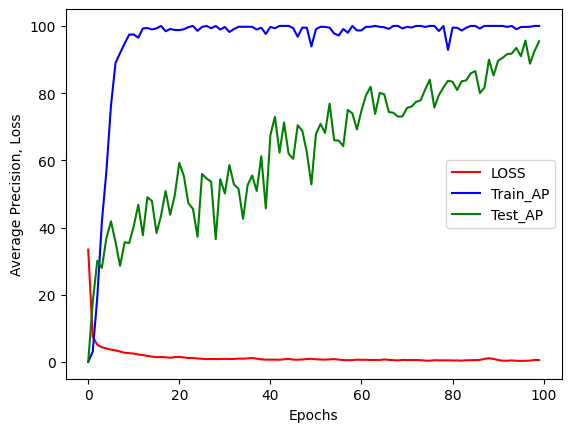

In [39]:
# plt.title("EXPERIMENTAL DETAILS OF STATISTICAL CNN")
plt.xlabel("Epochs")
plt.ylabel("Average Precision, Loss")
plt.plot(loss_arr,color='red',label='LOSS')
plt.plot(train_map,color='blue',label='Train_AP')
plt.plot(test_map,color='green',label='Test_AP')
plt.legend()
plt.show()

In [ ]:
def calculate_average_precision(recall, precision):
    """Calculate the average precision given the data points for recall and precision."""
    
    # Sort precision and recall in descending order of recall
    sorted_indices = sorted(range(len(recall)), key=lambda i: recall[i], reverse=True)
    sorted_precision = [precision[i] for i in sorted_indices]
    sorted_recall = [recall[i] for i in sorted_indices]

    # Initialize variables
    ap = 0.0
    max_precision = 0.0
    last_recall = -1.0

    # Calculate the area under the precision-recall curve
    for i in range(len(sorted_recall)):
        if sorted_recall[i] != last_recall:
            ap += max_precision * (sorted_recall[i] - last_recall)
            last_recall = sorted_recall[i]
            max_precision = 0.0
        if sorted_precision[i] > max_precision:
            max_precision = sorted_precision[i]

    return ap


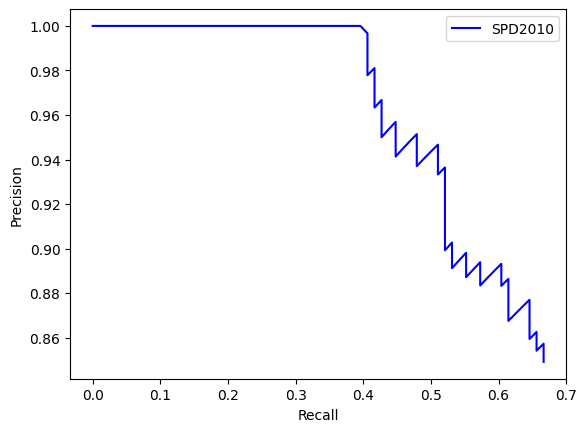

In [ ]:
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(r,p,color='blue',label="SPD2010")
# plt.plot(rsyn,psyn,color='orange',label="Synthetic")
plt.legend()
plt.show()

#Plot Images

In [ ]:
state_dict = torch.load('/content/drive/MyDrive/checkpoint.pth', map_location=DEVICE)
print(state_dict.keys())
model.load_state_dict(state_dict)
# net.load_state_dict(torch.load('classifier.pt', map_location=torch.device('cpu')))

FileNotFoundError: ignored

In [ ]:
# !unzip data_100.zip
# clean_data("data_100")
# test_dataset1 = VOCDataset(
#         os.path.join("data_100/test_csv.csv"), transform=transform, img_dir="data_100/images", label_dir="data_100/labels",
#     )
# test_loader1 = DataLoader(
#         dataset=test_dataset1,
#         batch_size=BATCH_SIZE,
#         num_workers=NUM_WORKERS,
#         pin_memory=PIN_MEMORY,
#         shuffle=True,
#         drop_last=True,
#     )

In [ ]:
!unzip data_100.zip
clean_data("data_100")
test_dataset2 = VOCDataset(
        os.path.join("spd_data_100/test_csv.csv"), transform=transform, img_dir="spd_data_100/images", label_dir="spd_data_100/labels",
    )
test_loader2 = DataLoader(
        dataset=test_dataset2,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

In [ ]:
def show_results(expected, predictions):
  n = len(expected)
  # f, axarr = plt.subplots(n,2,figsize=(10, 10))
  for i in range(n):
    f, axarr = plt.subplots(1,2,figsize=(10, 10))
    image = expected[i][0]
    boxes = expected[i][1]
    im = np.array(image)
    im = np.transpose(im, (1, 2, 0))
    height, width, _ = im.shape
    axarr[0].imshow(im)
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] // 2
        upper_left_y = box[1] - box[3] // 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        axarr[0].add_patch(rect)
    axarr[0].axis('off')
    image = predictions[i][0]
    boxes = predictions[i][1]
    im = np.array(image)
    im = np.transpose(im, (1, 2, 0))
    height, width, _ = im.shape
    axarr[1].imshow(im)
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        axarr[1].add_patch(rect)
    axarr[1].axis('off')
    plt.show()

In [ ]:
def get_results(n,testLoader):
  expected = []
  predictions = []
  for i in range(n):
    dataiter = iter(testLoader)
    images,labels = next(dataiter)
    image = images[0]
    label = labels[0].unsqueeze(0)
    output = model(image.unsqueeze(0).to(DEVICE))
    output = output.reshape(-1,7,7,30)
    boxes = cellboxes_to_boxes(output, S=7)
    boxes = torch.tensor(boxes).squeeze(0)
    # print(boxes.shape)
    boxes = boxes.tolist()
    nms_boxes = non_max_suppression(boxes, 0.5, 0.4)
    lable_box = cellboxes_to_boxes(label, S=7)
    lable_box = torch.tensor(lable_box).squeeze(0)
    expected.append((image, lable_box))
    predictions.append((image, nms_boxes))
  
  return expected,predictions

In [ ]:
def show_img_result(img_name):
  test_image = Image.open(data_name+"/images/"+img_name)
  # test_image = test_image.rotate(180,expand=True)
  label_file = open(data_name+"/labels/"+img_name.split(".")[0]+".txt","r")
  test_bboxes = [[float(i) for i in line.split()] for line in label_file.readlines()]
  test_image_tensor = transform(test_image,test_bboxes)

  output = model(test_image_tensor[0].unsqueeze(0).to(DEVICE))
  output = output.reshape(-1,7,7,30)
  boxes = cellboxes_to_boxes(output, S=7)
  boxes = torch.tensor(boxes).squeeze(0)
  boxes = boxes.tolist()
  nms_boxes = non_max_suppression(boxes, 0.5, 0.4)
  print(nms_boxes)
  return nms_boxes


In [ ]:
print(show_img_result("03077.jpg"))

In [ ]:
def impression_wise_results(person):
  f_test = open(data_name+"/test_csv.csv")
  list2 = [row.split()[0].split(",")[0] for row in f_test]
  imp_list = []
  for i in list2:
    if i.split(".")[0][2:]==person:
      imp_list.append(i)
  print(imp_list)
  f, axarr = plt.subplots(1,len(imp_list),figsize=(20, 5))
  for i in range(len(imp_list)):
    img_name = imp_list[i]
    test_image = Image.open(data_name+"/images/"+img_name)
    # test_image = test_image.rotate(180,expand=True)
    label_file = open(data_name+"/labels/"+img_name.split(".")[0]+".txt","r")
    test_bboxes = [[float(i) for i in line.split()] for line in label_file.readlines()]
    image = transform(test_image,test_bboxes)[0]
    boxes = show_img_result(img_name)
    im = np.array(image)
    im = np.transpose(im, (1, 2, 0))
    height, width, _ = im.shape
    axarr[i].imshow(im)
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] // 2
        upper_left_y = box[1] - box[3] // 2
        rect = patches.Rectangle(
            (upper_left_y * width, upper_left_x * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        axarr[i].add_patch(rect)
f_test = open(data_name+"/test_csv.csv")
list2 = [row.split()[0].split(",")[0] for row in f_test]
person_list = []
for i in list2:
  p=i.split(".")[0][2:]
  if p not in person_list:
    person_list.append(p)
random.shuffle(person_list)
person_list=person_list[0:5]
for p in person_list:
  impression_wise_results(p)

In [ ]:
res = get_results(10,test_loader)
show_results(res[0],res[1])

In [ ]:
res1 = get_results(10,test_loader2)
show_results(res1[0],res1[1])